In [56]:
# code for reading a .dat file
import numpy as np
from netCDF4 import Dataset
import netCDF4 as nc4
from myFunctions import lcl
import matplotlib.pyplot as plt
import pandas as pd
import glob
import datetime

%matplotlib inline  
date='20130502'
PathIn = '/Users/cacquist/Lavoro/PBL_hdcp2_s2/PBL_hdcp2_s2_minion/'
fileList = glob.glob(PathIn+'KIT_HOPE_2013050207.txt')

cols = ['time [min:sec]','P [hPa]','T [C]','U [%]','Wind speed [m/s]','Wdir [∞]','Lange [∞]'\
        ,'Breite [∞]','Hˆhe [m]','Geo Pot [m]', 'dew [C]', 'Tv [C]','Rs [m/s]', 'D [kg/m3]', \
        'Azimut []','Elevation []','Entfernung [m]']
DF = pd.read_csv(PathIn+'KIT_HOPE_2013050207.txt', delim_whitespace=True,  names=cols, header=None)


1006.3
0.0
286.04999999999995
282.15


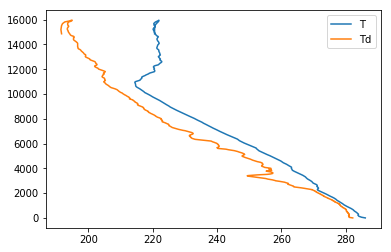

In [21]:
# ---- reading variables in the file
time = DF.values[:,0]
datetime = '2013-05-02 07:00:00'
P = DF.values[:,1]
T = DF.values[:,2]
U = DF.values[:,3]
Hwind = DF.values[:,4]
Wdir = DF.values[:,5]
Td = DF.values[:,10]
Td = Td + 273.15
T = T + 273.15
height = DF.values[:,8]
Ndata = len(DF.count(axis='columns'))

print(P[0])
print(height[0])
print(T[0])
print(Td[0])
plt.plot(T, height, label='T')
plt.plot(Td, height, label='Td')
plt.legend()

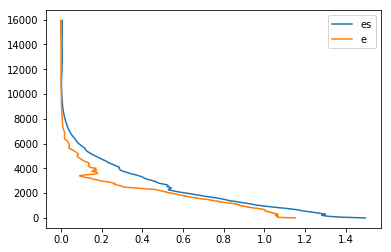

In [43]:
# ---- Calculating RH for radiosondes from Td (Td = 1/To - Rv/L log(e/eo)^-1) from stull
# RH = e/es ; es is from clausius clapeyron while e is obtained from the formula for td 
e0 = 0.611 # Hpa
T0 = 273.15 # K
cost_lrv = 5423. # K (Lv/Rv)

e = []
es = []
RH = []
for indData in range(Ndata):
    e.append(e0 * np.exp(cost_lrv*(T0**(-1)-Td[indData]**(-1))))
    es.append(e0 * np.exp(cost_lrv*(T0**(-1)-T[indData]**(-1))))
    RH.append(100*(e0 * np.exp(cost_lrv*(T0**(-1)-Td[indData]**(-1))))/(e0 * np.exp(cost_lrv*(T0**(-1)-T[indData]**(-1)))))

#plt.plot(e, T, label='e')
plt.plot(es, height, label='es')
plt.plot(e, height, label='e')
plt.legend()
    
# ---- finding height where RH = 100%
ind_sat = []
for indData in range(1,Ndata,+1):
    if ((RH[indData-1] < 100.) and (RH[indData] > 100.)):
        ind_sat = indData
        break

(0.0, 100.0)

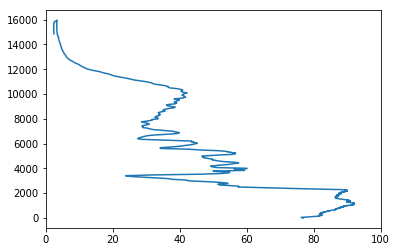

In [48]:
plt.plot(RH, height)
plt.xlim(0.,100.)

948.1
289.47137999999995


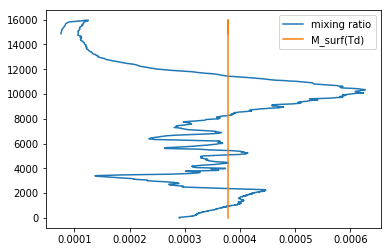

In [65]:
# ---- calculating CCL from radiosoundings
# ---- calculating the saturation mixing ratio for td at the surface (assuming RH =100%)
# defining constants
cost_rvl = np.power(5423,-1.) #K
Rv = 461 # J K^-1 Kg^-1
epsilon = 0.622 
Td_surf = Td[0]
P_surf = P[0]
T_surf = T[0]
M0 = epsilon*e0*np.exp((1./Rv)*(T0**(-1.)-Td_surf**(-1.))) / \
(P_surf - e0*np.exp((1./Rv)*(T0**(-1.)-Td_surf**(-1.))))

# ---- calculating mixing ratio profile for each P,T, RH using profile RH
m =[]
arg_exp = np.array((1./Rv)*(T0**(-1.)-T**(-1.)))
for indData in range(Ndata):
    m.append((RH[indData]/100.)*epsilon*e0*np.exp(arg_exp[indData]) / (P[indData] - (RH[indData]/100.)*e0*np.exp(arg_exp[indData])))


for indData in range(1,Ndata):
    if ((m[indData-1] < M0) and (m[indData] > M0)):
        ind_CCL = indData
        break
        
        
z_ccl = height[ind_CCL]
print(z_ccl)

plt.plot(m, height, label='mixing ratio')
plt.plot(np.repeat(M0,Ndata), height, label='M_surf(Td)')
plt.legend()


Ad_rate = -9.8 # K/Km
T_ground_CCL = []
# ---- finding z(CCL) using the dry adiabatic lapse rate
T_top = T[ind_CCL]
T_ground_CCL = T_top - Ad_rate* z_ccl*10.**(-3)

print(T_ground_CCL)

In [64]:
# ---- calculating LCL height
#------ calculating LCL heights from tower measurements resampled
#---------------------------------------------------------------------------------
from myFunctions import lcl
print(np.array(P_surf))
print(np.array(T_surf))
print(np.array(RH[0]))
LCL = lcl(np.array(P_surf),np.array(T_surf),np.array(RH[0])/100.)
print(LCL)
    

1006.3
286.04999999999995
76.9473458800561
nan
